In [75]:
#Basic Packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix


#Plot Maps
import folium
from folium.plugins import HeatMap, MarkerCluster 

#Functions
import Functions

# Umap library
import umap

%load_ext autoreload
%autoreload 2

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Importing Data and pre processing

In [76]:
individuals = pd.read_csv('clientes_preprocessed.csv')
transactions = pd.read_csv('Customer Basket Dataset.csv')
prod_mapping = pd.read_excel('Product Mapping Excel File.xlsx')

In [77]:
individuals.set_index('customer_id', inplace=True)

In [78]:
individuals['lifetime_spend_animal_protein'] = individuals[['lifetime_spend_fish', 'lifetime_spend_meat']].sum(axis=1)
individuals['lifetime_spend_technology'] = individuals[['lifetime_spend_videogames', 'lifetime_spend_electronics']].sum(axis=1)

Scalling Data

In [119]:
scaler = MinMaxScaler()
individuals_num = individuals.drop(['customer_name', 'region'], axis=1)
scaled_data = scaler.fit_transform(individuals_num)
scaled_data = pd.DataFrame(scaled_data, index= individuals_num.index, columns=individuals_num.columns)

#### Solution A

Temos aqui 18 variaveis

In [156]:
fit_variablesA = ['kids_home', 'teens_home',  'number_complaints',
 'distinct_stores_visited', 'lifetime_spend_groceries', 'typical_hour', 'lifetime_spend_hygiene',
 'lifetime_spend_vegetables','lifetime_spend_nonalcohol_drinks','lifetime_spend_alcohol_drinks','lifetime_total_distinct_products','percentage_of_products_bought_promotion',
 'year_first_transaction','loyalty_card','total_lifetime_spend',
 'lifetime_spend_animal_protein','lifetime_spend_videogames', 'lifetime_spend_electronics']

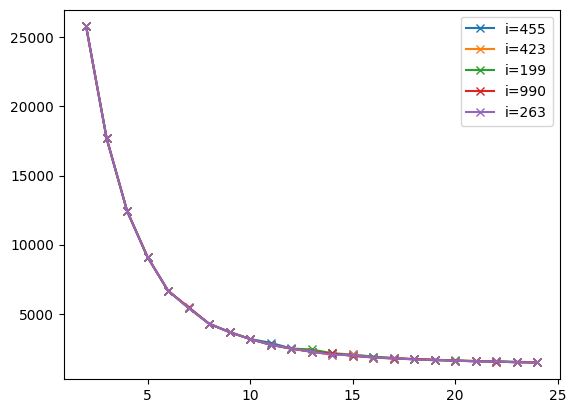

In [155]:
Functions.plot_inertia(scaled_data[fit_variablesA], 25, 5)

In [158]:
kmeans_sol_new = KMeans(n_clusters=6, random_state=0).fit(scaled_data[fit_variablesA])
individuals['cluster_kmeans_new'] =  kmeans_sol_new.predict(scaled_data[fit_variablesA])

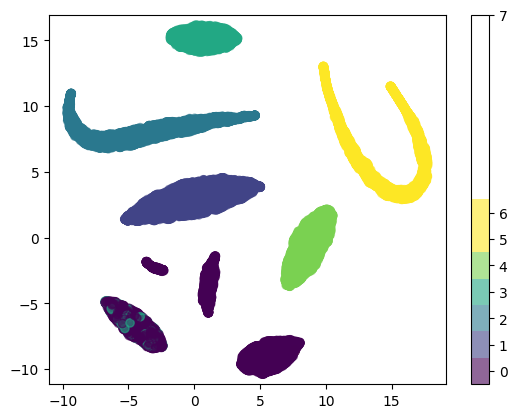

In [161]:
reducer = umap.UMAP(random_state=42)
labels_new = individuals['cluster_kmeans_new'].values
embedding_new = reducer.fit_transform(individuals_num)
plt.scatter(embedding_new[:, 0], embedding_new[:, 1], c=labels_new, cmap='viridis', alpha=0.6)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(8)-0.5).set_ticks(np.arange(8))
plt.show()

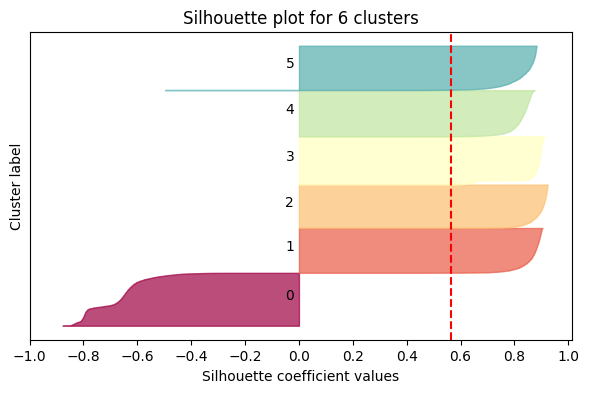

Silhouette score for 6 clusters: 0.5643


In [162]:
Functions.silhoette_method(individuals.drop(['customer_name', 'region'], axis=1), 'cluster_kmeans_new')

## Agora vamos só analisar o cluster 0 desta soluçao!

In [164]:
abnormal_cluster = individuals[individuals['cluster_kmeans_new'] == 0]

In [165]:
scaler = MinMaxScaler()
abnormal_cluster_new = abnormal_cluster.drop(['customer_name', 'region'], axis=1)
scaled_data2 = scaler.fit_transform(abnormal_cluster_new)
scaled_data2 = pd.DataFrame(scaled_data2, index= abnormal_cluster_new.index, columns=abnormal_cluster_new.columns)

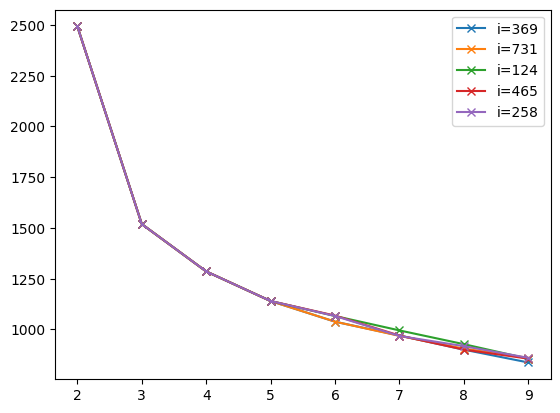

In [167]:
Functions.plot_inertia(scaled_data2[fit_variablesA], 10, 5)

In [168]:
kmeans_sol_extra = KMeans(n_clusters=3, random_state=0).fit(scaled_data2[fit_variablesA])
abnormal_cluster['cluster_kmeans_extra'] =  kmeans_sol_extra.predict(scaled_data2[fit_variablesA])

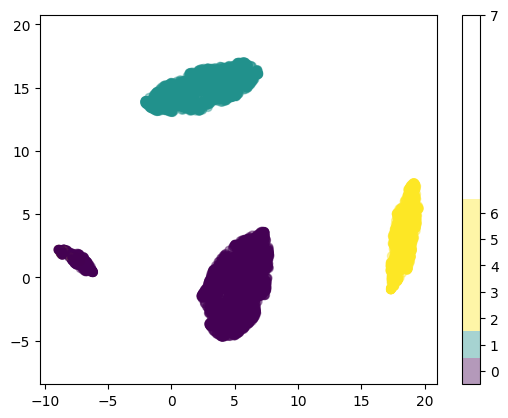

In [170]:
reducer = umap.UMAP(random_state=42)
labels_new = abnormal_cluster['cluster_kmeans_extra'].values
embedding_new = reducer.fit_transform(abnormal_cluster_new)
plt.scatter(embedding_new[:, 0], embedding_new[:, 1], c=labels_new, cmap='viridis', alpha=0.4)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(8)-0.5).set_ticks(np.arange(8))
plt.show()

In [171]:
Functions.compare_clusters(abnormal_cluster, 'cluster_kmeans_extra')

,0,1,2,general_mean
customer_gender,0.496676,0.503027,0.499206,0.499290
kids_home,0.511146,0.166758,0.015873,0.289315
teens_home,0.522487,0.000000,0.000000,0.237132
number_complaints,0.924912,0.018162,0.025397,0.431310
distinct_stores_visited,1.894799,3.007155,1.990476,2.274938
lifetime_spend_groceries,569.010559,6996.068795,101.350794,2537.188321
lifetime_spend_electronics,541.626515,1004.877270,19.808730,574.327299
typical_hour,13.464998,18.958723,21.496825,17.033014
lifetime_spend_vegetables,279.146656,402.068244,20.872222,261.028576
lifetime_spend_nonalcohol_drinks,279.102073,400.819483,198.960317,300.433617


### Solução B: Nova solução de clustering que agora só recorre aos lifetime spends


Recorre a 10 variaveis

In [172]:
fit_variablesB = [ 'lifetime_spend_groceries', 'lifetime_spend_hygiene',
 'lifetime_spend_vegetables','lifetime_spend_nonalcohol_drinks','lifetime_spend_alcohol_drinks','lifetime_total_distinct_products',
 'year_first_transaction','lifetime_spend_animal_protein','lifetime_spend_videogames', 'lifetime_spend_electronics']

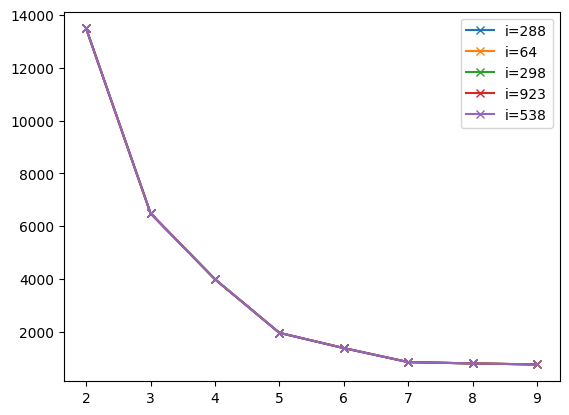

In [173]:
Functions.plot_inertia(scaled_data[fit_variablesB], 10, 5)

In [175]:
kmeans_sol_spends = KMeans(n_clusters=5, random_state=0).fit(scaled_data[fit_variablesB])
individuals['cluster_kmeans_spends'] =  kmeans_sol_spends.predict(scaled_data[fit_variablesB])

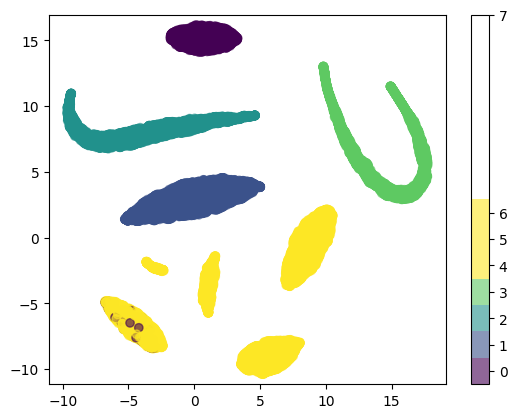

In [176]:
reducer = umap.UMAP(random_state=42)
labels_new = individuals['cluster_kmeans_spends'].values
embedding_new = reducer.fit_transform(individuals_num)
plt.scatter(embedding_new[:, 0], embedding_new[:, 1], c=labels_new, cmap='viridis', alpha=0.6)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(8)-0.5).set_ticks(np.arange(8))
plt.show()

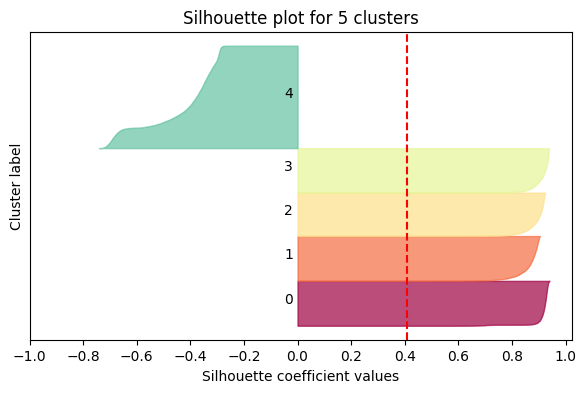

Silhouette score for 5 clusters: 0.4092


In [177]:
Functions.silhoette_method(individuals.drop(['customer_name', 'region'], axis=1), 'cluster_kmeans_spends')

### Solução C: Sem Scalling - isto pode se fazer?

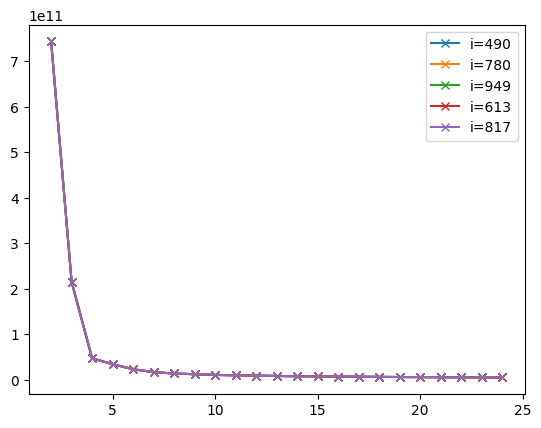

In [194]:
Functions.plot_inertia(individuals_num[fit_variablesA], 25, 5)

In [195]:
kmeans_sol_no_scale = KMeans(n_clusters=4, random_state=0).fit(individuals_num[fit_variablesA])
individuals['cluster_kmeans_no_scale'] =  kmeans_sol_no_scale.predict(individuals_num[fit_variablesA])

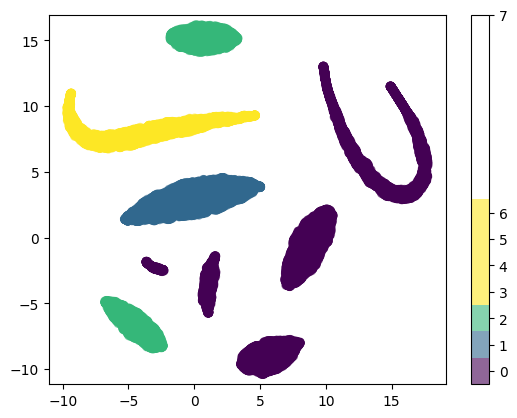

In [196]:
reducer = umap.UMAP(random_state=42)
labels_new = individuals['cluster_kmeans_no_scale'].values
embedding_new = reducer.fit_transform(individuals_num)
plt.scatter(embedding_new[:, 0], embedding_new[:, 1], c=labels_new, cmap='viridis', alpha=0.6)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(8)-0.5).set_ticks(np.arange(8))
plt.show()

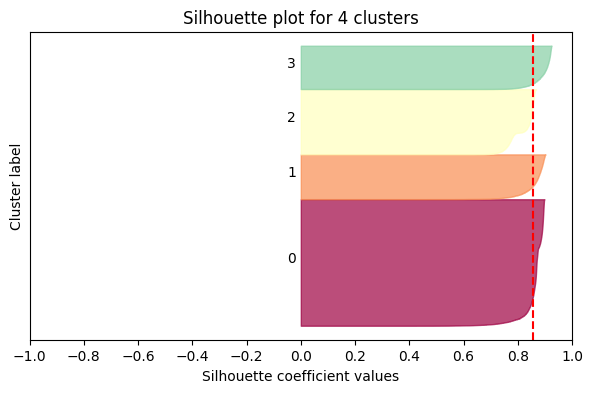

Silhouette score for 4 clusters: 0.8576


In [198]:
Functions.silhoette_method(individuals.drop(['customer_name', 'region'], axis=1), 'cluster_kmeans_no_scale')

### Solução D: no scalling e 5 clusters

In [199]:
kmeans_sol_no_scale5 = KMeans(n_clusters=5, random_state=0).fit(individuals_num[fit_variablesA])
individuals['cluster_kmeans_no_scale5'] =  kmeans_sol_no_scale5.predict(individuals_num[fit_variablesA])

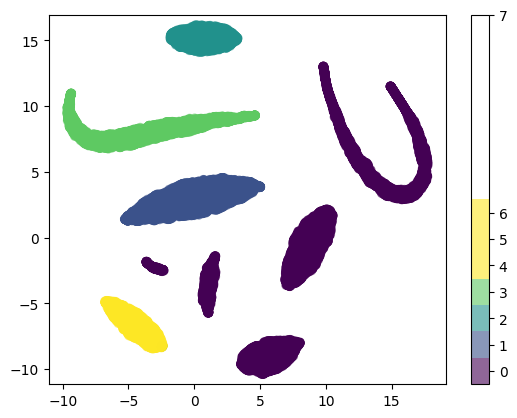

In [200]:
reducer = umap.UMAP(random_state=42)
labels_new = individuals['cluster_kmeans_no_scale5'].values
embedding_new = reducer.fit_transform(individuals_num)
plt.scatter(embedding_new[:, 0], embedding_new[:, 1], c=labels_new, cmap='viridis', alpha=0.6)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(8)-0.5).set_ticks(np.arange(8))
plt.show()

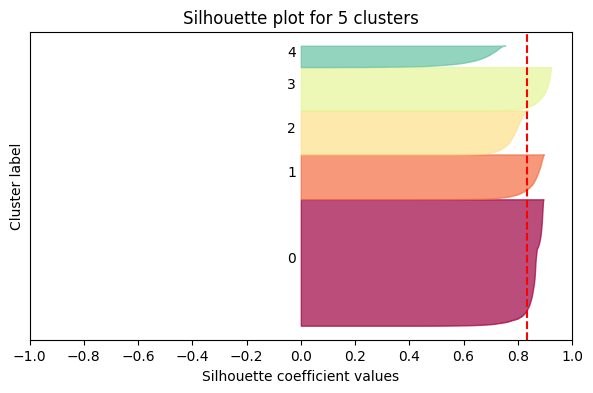

Silhouette score for 5 clusters: 0.8349


In [201]:
Functions.silhoette_method(individuals.drop(['customer_name', 'region'], axis=1), 'cluster_kmeans_no_scale5')

### Solução E: sem scalling 6

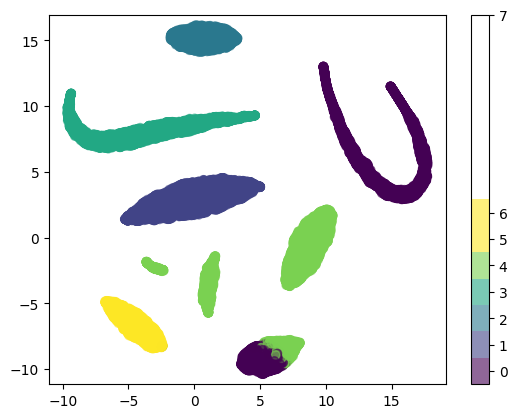

In [202]:
kmeans_sol_no_scale6 = KMeans(n_clusters=6, random_state=0).fit(individuals_num[fit_variablesA])
individuals['cluster_kmeans_no_scale6'] =  kmeans_sol_no_scale6.predict(individuals_num[fit_variablesA])

reducer = umap.UMAP(random_state=42)
labels_new = individuals['cluster_kmeans_no_scale6'].values
embedding_new = reducer.fit_transform(individuals_num)
plt.scatter(embedding_new[:, 0], embedding_new[:, 1], c=labels_new, cmap='viridis', alpha=0.6)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(8)-0.5).set_ticks(np.arange(8))
plt.show()

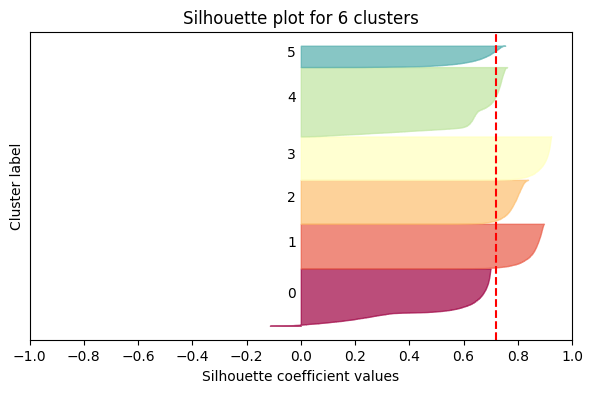

Silhouette score for 6 clusters: 0.7191


In [203]:
Functions.silhoette_method(individuals.drop(['customer_name', 'region'], axis=1), 'cluster_kmeans_no_scale6')